# CLIP Training Process

This file performs training on the CLIP base model using the downloaded astronomy images from save_cutout_pngs.ipynb

In [2]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from datasets import concatenate_datasets
from tqdm import tqdm  
import torch
import torch.optim as optim

In [3]:
# flips images for data augmentation
def augment_image(example):
    image = example["image"]
    
    # Apply horizontal flip
    flipped_image = transforms.functional.hflip(image)

    example["image"] = flipped_image 
    return example

In [4]:
# Creates data set using downloaded images and augmented images

dataset_path = "../data/sorted/train_pngs"
dataset = load_dataset("imagefolder", data_dir=dataset_path)

# Apply augmentation
augmented_dataset = dataset["train"].map(augment_image)

# Inspect dataset structure
print(dataset)
print(augmented_dataset)

Resolving data files:   0%|          | 0/944 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 944
    })
})
Dataset({
    features: ['image', 'label'],
    num_rows: 944
})


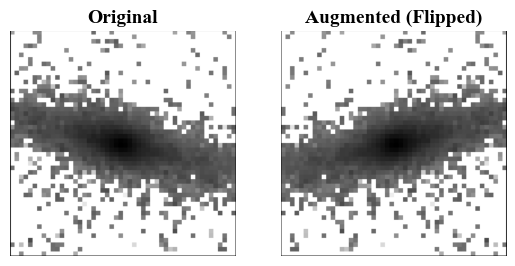

In [5]:
# Prints sample images for original data and augmented data
original = dataset["train"][940]["image"]
augmented = augmented_dataset[940]["image"]

fig, ax = plt.subplots(1, 2)
ax[0].imshow(original)
ax[0].set_title("Original", fontname="Times New Roman", fontsize=14, fontweight="bold")
ax[0].axis("off")

ax[1].imshow(augmented)
ax[1].set_title("Augmented (Flipped)",fontname="Times New Roman", fontsize=14, fontweight="bold")
ax[1].axis("off")

plt.show()


In [6]:
# text descriptions were generated from D. Maschmann paper (2024), 
# Labels were generated using email from D. Maschmann himself, and Whitemore paper (2021)

label_to_label = {
    "0": "1",
    "1": "4",
    "2": "4",
    "3": "4",
    "4": "4",
    "5": "2",
    "6": "3",
    "7": "4",
    "8": "4",
    "9": "4",
    "10": "4",
    "11": "4",
    "12": "4"
}

label_to_text_one = {
    "1": "globular cluster, central peak, symmetrical, slightly more extended than point source",
    "2": "open cluster, central peak, asymmetrical, elongated, slightly more extended relative to point source",
    "3": "compact stellar association, asymmetric, multiple peaks",
    "4": "not a star cluster or compact stellar association could be image artifacts, background galaxies, individual stars, or pairs of stars"
}


In [7]:
# Adds new labels and text descriptions to both origian and augmented data. Datasets are then concatenated to make one large training dataset
def add_new_labels(example):
    folder_name = example["label"] 
    example["label"] = label_to_label.get(str(folder_name), "Unknown Object")
    return example

def add_text_labels_one(example):
    folder_name = example["label"]  
    example["text"] = label_to_text_one.get(str(folder_name), "Unknown Object")
    return example


augmented_dataset = augmented_dataset.map(add_new_labels)
augmented_dataset = augmented_dataset.map(add_text_labels_one)

dataset = dataset['train']
dataset = dataset.map(add_new_labels)
dataset = dataset.map(add_text_labels_one)

print(dataset)
print(augmented_dataset)

con_dataset = concatenate_datasets([augmented_dataset, dataset])

print(con_dataset)

Map:   0%|          | 0/944 [00:00<?, ? examples/s]

Map:   0%|          | 0/944 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label', 'text'],
    num_rows: 944
})
Dataset({
    features: ['image', 'label', 'text'],
    num_rows: 944
})
Dataset({
    features: ['image', 'label', 'text'],
    num_rows: 1888
})


In [ ]:
device = "cuda" if torch.cuda.is_available() else \
         ("mps" if torch.backends.mps.is_available() else "cpu")

# Specifices version of CLIP to be used from huggingface 
model_id = "openAI/clip-vit-base-patch32"

# Loads the model, tokenizer, and processor
model = CLIPModel.from_pretrained(model_id).to(device)
tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)

In [ ]:
# Creates custom CLIP dataset suitable for training using the concatenated dataset above
class CustomDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        text = self.dataset[idx]['text']  

        inputs = self.processor(text=text, images=image, return_tensors="pt", padding="max_length", truncation=True)
        
        return {
            "input_ids": inputs["input_ids"].squeeze(0),  
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "pixel_values": inputs["pixel_values"].squeeze(0) 
        }

In [ ]:
# Ensures new dataset is proper format for batches in training process
def collate_fn(batch):

    input_ids = torch.nn.utils.rnn.pad_sequence(
        [item["input_ids"] for item in batch], batch_first=True, padding_value=0
    )
    attention_mask = torch.nn.utils.rnn.pad_sequence(
        [item["attention_mask"] for item in batch], batch_first=True, padding_value=0
    )
    pixel_values = torch.stack([item["pixel_values"] for item in batch]) 

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "pixel_values": pixel_values
    }


In [ ]:
# Finalizes dataset and loads dataloader
train_dataset = CustomDataset(con_dataset, processor)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

In [ ]:
# Specifies optimizer and scheduler for training
optimizer = optim.AdamW(model.parameters(),  lr=5e-6, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [ ]:
# Trains the model using cross-entropy loss and back propogation over 10 epochs using custom dataset and specified optimizer
# Tracks loss, accuracy, and timed progress via progress bar
for epoch in range(10):  
    epoch_loss = 0 
    batch_count = 0
    correct_predictions = 0
    total_samples = 0 

    # Wrap train_dataloader with tqdm for a progress bar
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{10}", leave=True)

    for batch in progress_bar:
        optimizer.zero_grad()

        # Forward pass
        input_ids = batch['input_ids'].squeeze(1)  
        attention_mask = batch['attention_mask'].squeeze(1)
        pixel_values = batch['pixel_values'].squeeze(1)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values)

        # Contrastive loss
        logits_per_image = outputs.logits_per_image 
        logits_per_text = outputs.logits_per_text  
        labels = torch.arange(logits_per_image.size(0)).to(logits_per_image.device)

        loss_image = torch.nn.CrossEntropyLoss()(logits_per_image, labels)
        loss_text = torch.nn.CrossEntropyLoss()(logits_per_text, labels)
        loss = (loss_image + loss_text) / 2

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track loss
        epoch_loss += loss.item()

        # Compute accuracy
        predictions = torch.argmax(logits_per_image, dim=1)  
        correct_predictions += (predictions == labels).sum().item()
        total_samples += labels.size(0)
        
        batch_count += 1

        # Update progress bar with loss info
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    avg_loss = epoch_loss / batch_count
    accuracy = (correct_predictions / total_samples) * 100

    print(f"\nEpoch [{epoch+1}/10] Completed, Average Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%\n")


Epoch 1/10: 100%|██████████| 154/154 [08:49<00:00,  3.44s/it, loss=0.8627]



Epoch [1/10] Completed, Average Loss: 1.7628, Accuracy: 26.85%



Epoch 2/10: 100%|██████████| 154/154 [09:08<00:00,  3.56s/it, loss=1.0400]



Epoch [2/10] Completed, Average Loss: 1.5651, Accuracy: 31.24%



Epoch 3/10: 100%|██████████| 154/154 [11:46<00:00,  4.59s/it, loss=1.0208]



Epoch [3/10] Completed, Average Loss: 1.4568, Accuracy: 34.09%



Epoch 4/10: 100%|██████████| 154/154 [09:22<00:00,  3.66s/it, loss=0.4364]



Epoch [4/10] Completed, Average Loss: 1.3172, Accuracy: 36.45%



Epoch 5/10: 100%|██████████| 154/154 [09:47<00:00,  3.82s/it, loss=0.9560]



Epoch [5/10] Completed, Average Loss: 1.1971, Accuracy: 39.87%



Epoch 6/10: 100%|██████████| 154/154 [07:26<00:00,  2.90s/it, loss=0.7467]



Epoch [6/10] Completed, Average Loss: 1.0831, Accuracy: 42.07%



Epoch 7/10: 100%|██████████| 154/154 [10:05<00:00,  3.93s/it, loss=1.1064]



Epoch [7/10] Completed, Average Loss: 1.0643, Accuracy: 42.80%



Epoch 8/10: 100%|██████████| 154/154 [07:26<00:00,  2.90s/it, loss=0.6647]



Epoch [8/10] Completed, Average Loss: 0.9900, Accuracy: 43.86%



Epoch 9/10: 100%|██████████| 154/154 [07:13<00:00,  2.81s/it, loss=0.5649]



Epoch [9/10] Completed, Average Loss: 0.9735, Accuracy: 44.43%



Epoch 10/10: 100%|██████████| 154/154 [07:16<00:00,  2.84s/it, loss=0.5726]


Epoch [10/10] Completed, Average Loss: 1.0181, Accuracy: 43.78%



In [ ]:
# Saves the trained model and processor to specified folder
model.save_pretrained("fine_tuned_clip_model")
processor.save_pretrained("fine_tuned_clip_model")